# HW 1 - Report : KNN & ANN
#### Submitted by: Adir Hilvert, Tal Mirovsky
---------------------------------------

**Introduction:** <br>
In the following report we will examine 2 datasets : Hananya & Hashmal.<br>
Each data set is divided into training set (Hananya1 & Hashmal1) and testsets (Hananya2 & Hashmal2).<br>
Data stored in the datasets represents pixels labels and 128 features for each pixel.<br>

**Objective:**<br>
For each pixel (point) in the test datasets, we are required to find the matching point (the point which indicates the same location) in the training set image.

**Method:** <br>
We chose the LSH data structure for the implementation of the ANN algorithm, the ANN will retrieve the K nearest neighbors and thier distances from the test point.


**General notes:**

1. Tasks 1-7 were performed on both Hananya and Hashmal datasets in this notebook, bonus tasks (8,9) are <br>
submitted in another notebook, named 'Bonus-questions'.<br>
<br>
2. Assumptions (according to answers given in class and councling hours): <br>
     - No Data cleaning is required.
     - No data normalization is needed for the 128 dimensions.
     - Due to long runtimes, range values of hyper parameters (K,L) were restricted to ranges which yielded reasoable   runtimes,<br>e.g., it is clear that we could have continued increasing L above 20 (num of tables), the accuracy would keep increasing, but runtime (especially on Hashmal) will be hours ,espcially on task 4.<br>
<br>     
4. The original Hananya & Hashmals csv files were used, before the X and Y coordinates were switched, the switch was       performed inside the code which plots the points on the images.<br>
<br>
5. We used 100 combinations of (K,L) on task 4 (10 values each), as per the original requirement since this task was          already completed when the email with the clarification (which allowed the use of only 5 values) was received.  

**Imported functions and Global parameters for tasks 1-7**

In [90]:
from sklearn.neighbors import NearestNeighbors   
from time import perf_counter  # for runtime measurements
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt; plt.rcdefaults() # for diagrams plot
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown as md
import itertools  #used the islice method to get 5 best (k,l) combinations in task 5.


# Creating global variables which will be used to access the datasets
data_train = ['Hananya1.csv', 'Hashmal1.csv']
data_test = ['Hananya2.csv', 'Hashmal2.csv']
train_picture = ['Hananya1.jpg', 'Hashmal1.jpg']
test_picture = ['Hananya2.jpg', 'Hashmal2.jpg']

## Task1:

 KNN Implementation - Brute Force
 ---------------------------------------------------------

In [4]:
class KNN:
    def __init__(self):
        self.point_x_features = []
        self.point_y_features = []
        self.result_array = []

    def fit(self, dataframe):
#       Omitting the first 4 columns of each row and keeping the features
        self.point_x_features = np.array(dataframe)[:, 4:]

    def kneighbors(self, testset, k):
        self.point_y_features = testset
        for point_y in self.point_y_features:
            self.result_array.append([self.get_neighbours_for_point(point_y[4:], k), point_y[:4]])
        return (self.result_array)

    def get_neighbours_for_point(self, point_y, k):
        self.neighbours = []
#           Compute distances between x and all examples in the training set
        for point_x in enumerate(self.point_x_features):
            dst = euclidean(point_x[1], point_y)
            self.neighbours.append([point_x[0], dst])
#           Sort points by distance and return indices of the first k neighbors
        self.neighbours = np.array(self.neighbours)
        k_idx = self.neighbours[:, 1].argsort()[:k]
        return (self.neighbours[k_idx])
        
     

## Task 2

ANN Implementaion - LSH 
-----------------------------

Implemetation explanation:
- ANN is the main class with the methods stated in the requirements.
- LSH is the class which is responsible for the LSH data structure opearations.
- Hashtable is the class responsible for operations of each individual hash table.


Class HashTable:

In [5]:
class HashTable:
    def __init__(self, hash_size, inp_dimensions):
        self.hash_size = hash_size                     #k
        self.inp_dimensions = inp_dimensions           #D
        self.hash_table = dict()
        self.projections = np.random.randn(self.hash_size, inp_dimensions)       #randomize matrix K*D

    def generate_hash(self, list_features):
#       generate hash key using a dot product of point y features and projection matrix.
        bools = (np.dot(list_features, self.projections.T) > 0).astype('int')
        return ''.join(bools.astype('str'))

    def __setTable__(self, list_features, value):
#       Inserting values to specific cell according to the calulcated hash key
        hash_value = self.generate_hash(list_features)
        self.hash_table[hash_value] = self.hash_table.get(hash_value, list()) + [value]

    def __getTable__(self, list_features):
#       calculate a hash key for point_y and returns neighbors in the same cell,
#       returns empty list if no neighbors are found
        hash_value = self.generate_hash(list_features)
        return self.hash_table.get(hash_value, [])

Class LSH:

In [6]:
class LSH:
    def __init__(self, num_tables, hash_size, inp_dimensions):
        self.num_tables = num_tables             # L - hash tables
        self.hash_size = hash_size               # K - hash size
        self.inp_dimensions = inp_dimensions     # D - dimensions size
        self.hash_tables = list()
        for i in range(self.num_tables):
#           Creates L hash tables  
            self.hash_tables.append(HashTable(self.hash_size, self.inp_dimensions))

    def __setitem__(self, index_x, list_features):
        for table in self.hash_tables:
#           call to set function of HashTable
            table.__setTable__(list_features, index_x)     

    def union_points(self, point_y):
#       Iterate all hash tables, returns a list of all possible neighbors found in each table
        union_points= list()
        for table in self.hash_tables:
            union_points.extend(table.__getTable__(point_y))
        uni_list = np.unique(np.asarray(union_points))
        return uni_list

Class ANN:

In [7]:
class ANN:

    def __init__(self, l, k, d):
        self.point_x_features = []
        self.features_vectors_y = []
        self.point_x_names = []
        self.lsh = LSH(l, k, d)
        self.result_array = []
        self.result_dist_array = []

    def fit(self, dataframe):
        self.point_x_features = np.array(dataframe)[:, 4:]
        self.point_x_names = np.array(dataframe)[:, :4]
        # Mapping each point in training dataset to hash value and inserts them to tables
        for x in enumerate(self.point_x_features):
            self.lsh.__setitem__(x[0], x[1])

    def kneighbors(self, testset, k):
        # Dividing testset to points labels and features
        #In case the testset includes multiple rows
        if len(testset.shape) > 1:
            self.features_vectors_y = testset[:, 4:]
            points_labels_y = testset[:, :4]
        else:  
        # In case only 1 row was included in testset
            self.features_vectors_y = testset[4:]
            points_labels_y = testset[:4]

        for vector_y in enumerate(self.features_vectors_y):
            neighbors_for_point_y = self.getneighbors(vector_y[1], k)
            self.result_array.append([neighbors_for_point_y, vector_y[0]])
        return self.result_array

    def getneighbors(self, vector_y, k):
        # Calulates euclidean distance for each possible neighbors found by 'union_points' method 
        # returns distance and index of each neighbor         
        temp_neighbors_array = []
        neighbors = self.lsh.union_points(vector_y)
        for n in neighbors:
            distance = euclidean(vector_y, self.point_x_features[n])
            temp_neighbors_array.append([n, distance])
        if (not temp_neighbors_array) or (len(temp_neighbors_array) < k):
            # In case less than k neighbors are found - returns None
            return None
        else:
            neighbors_array_numpy = np.array(temp_neighbors_array, dtype=object,ndmin=2)
            # Sorting the list of neigbors by distance and returning the k nearest neigbors 
            k_idx = np.argsort(neighbors_array_numpy[:, 1])[:k]
            return neighbors_array_numpy[k_idx]


## Task 3
Calculting ratios and finding 10 best points in the testsets for checking ANN validity.

### Function for calculating ratios of each points

In [8]:
def calc_ratio(results):
    ratios_list = []
    for i in range(len(results)):
#       The ANN results were stored in a 4D array so the distances for the neighbors are retrieved by 4D indexes below]
        first_neighbor_distance = results[i][0][0][1]
        second_neighbour_distance = results[i][0][1][1]
        ratios_list.append(first_neighbor_distance / second_neighbour_distance)
    return ratios_list

### Hananya Dataset
Executing the constructor,fit and kneighbors methods for the ANN and save results in array.

In [9]:
l = 2      # number of hash tables
k = 4      # number of cuts and values for hash key calculation
d = 128    # number of dimentions
k_neighbors = 2 # number of wanted nearset neighbors


df_train_Hananya = pd.read_csv(data_train[0])
df_test_Hananya = pd.read_csv(data_test[0])
df_test_numpy_Hananya = df_test_Hananya.to_numpy()

ann_instance = ANN(l, k, d)
ann_instance.fit(df_train_Hananya)
results = ann_instance.kneighbors(df_test_numpy_Hananya, k_neighbors)

#### Displaying 10 best ratios of points in dataframe
#### Results format:
**2NN** : [index of nearest neighbor , dNN], [ index of second nearset neighbor, dSNN] <br>
**Test_point** : chosen points from the test dataset <br>
**Ratio** : dNN \ dSNN


In [10]:
df_10_best_ratios = pd.DataFrame(results, columns = ['2NNs','Test_point'])
ratio = []
for result in enumerate(results):
    ratio.append(results[result[0]][0][0][1]/results[result[0]][0][1][1])
df_10_best_ratios['Ratio'] = ratio

df_10_best_ratios = df_10_best_ratios[(df_10_best_ratios.Ratio < 0.8)]

df_10_best_ratios = df_10_best_ratios.nsmallest(10, 'Ratio')
df_10_best_ratios

,2NNs,Test_point,Ratio
580,"[[516, 146.482080815368], [514, 336.2261143932...",580,0.435665
451,"[[303, 98.13765841918178], [580, 179.908309980...",451,0.545487
574,"[[507, 211.95046591125956], [521, 373.86494887...",574,0.566917
826,"[[511, 234.24986659547963], [538, 401.69017911...",826,0.583161
206,"[[192, 88.75809822207775], [421, 149.194503920...",206,0.594915
377,"[[351, 234.8850782829765], [228, 367.187962765...",377,0.639686
584,"[[522, 127.90621564255585], [268, 199.04270898...",584,0.642607
379,"[[354, 203.4649847025281], [250, 314.324672910...",379,0.647308
638,"[[580, 90.41570660012562], [139, 138.311243216...",638,0.653712
41,"[[734, 237.25513693068902], [741, 360.45804194...",41,0.658205


## Analysis of results of 10 best points according to ratio 

Displaying images and ploting the points

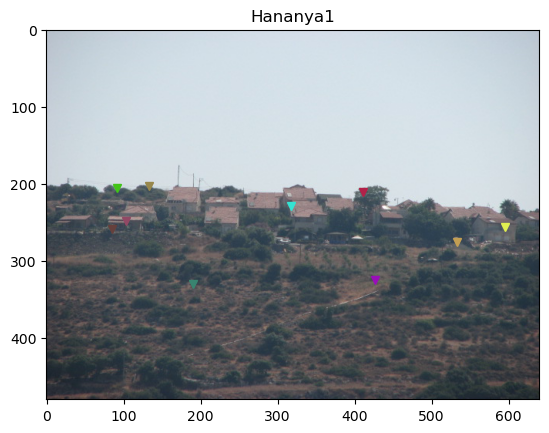

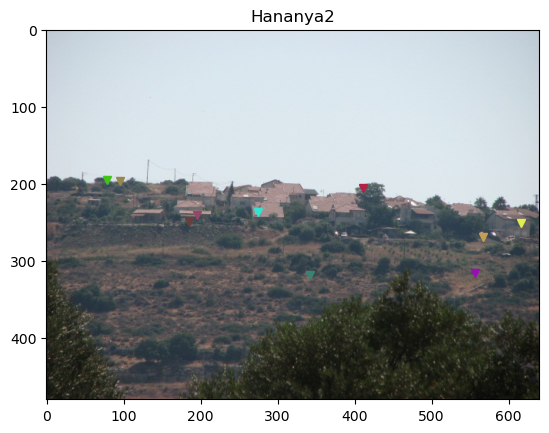

In [17]:
x = np.random.rand(10)
y = np.random.rand(10)
z = np.random.rand(10)

data = plt.imread('Hananya1.jpg')
for row  in enumerate(df_10_best_ratios.values):
    plt.plot(df_train_Hananya.Y[df_10_best_ratios.values[row[0]][0][0][0]],
             df_train_Hananya.X[df_10_best_ratios.values[row[0]][0][0][0]], marker='v',
             color=(x[row[0]], y[row[0]], z[row[0]]))
label = 'Hananya1'
plt.title(label, fontdict=None, loc='center')
plt.imshow(data)
plt.show()

data = plt.imread('Hananya2.jpg')
for row  in enumerate(df_10_best_ratios.values):
    ind = df_10_best_ratios.values[row[0]][1]
    plt.plot(df_test_Hananya.values[ind][1],
             df_test_Hananya.values[ind][0], marker='v',
             color=(x[row[0]], y[row[0]], z[row[0]]))
label = 'Hananya2'
plt.title(label, fontdict=None, loc='center')
plt.imshow(data)
plt.show()



**Conclusion:** <br>
Judging from the images, all 10 points in Hananya1 and Hananya2 match as can be seen in the images.

**Remarks:** <br>
* We are aware that in some executions, not all 10 points will necessarily match. This is explained by the fact that the image includes points which have almost similar features (looks the same).
Examples for such points: trees (green areas)

* Some areas in the image will probably never receive a ratio of < 0.8. For example the sky area, this is because each point in the sky looks similar to all the other points in the sky. Meaning, the nearest neighbor and the second nearest neighbor will probably be at almost the same euclidean distance. 

### Hashmal Dataset
Executing the constructor,fit and kneighbors methods for the ANN and save results in array.

In [28]:
l = 10      # number of hash tables
k = 15      # number of cuts and values for hash key calculation
d = 128    # number of dimentions
k_neighbors = 2 # number of wanted nearset neighbors


df_train_Hashmal = pd.read_csv(data_train[1])
df_test_Hashmal = pd.read_csv(data_test[1])
df_test_numpy_Hashmal = df_test_Hashmal.to_numpy()

ann_instance = ANN(l, k, d)
ann_instance.fit(df_train_Hashmal)
results = ann_instance.kneighbors(df_test_numpy_Hashmal,k_neighbors)

#### Displaying 10 best ratios of points in dataframe

In [29]:
df_10_best_ratios = pd.DataFrame(results, columns = ['2NNs','Test_point'])
ratio = []
for result in enumerate(results):
    if result[1][0] is not None:
        ratio.append(results[result[0]][0][0][1]/results[result[0]][0][1][1])
    else:
        ratio.append(1)
        
df_10_best_ratios['Ratio'] = ratio

df_10_best_ratios = df_10_best_ratios[(df_10_best_ratios.Ratio < 0.8)]

df_10_best_ratios = df_10_best_ratios.nsmallest(10, 'Ratio')
df_10_best_ratios

,2NNs,Test_point,Ratio
2331,"[[2446, 69.79254974565696], [3727, 375.5728957...",2331,0.185830
3064,"[[3172, 92.36341266973628], [2690, 345.6949522...",3064,0.267182
2237,"[[1785, 96.85556256612213], [2651, 325.6915718...",2237,0.297384
2232,"[[2368, 133.0], [1227, 397.13473784094987]]",2232,0.334899
1622,"[[2343, 113.50770898930169], [2702, 319.429178...",1622,0.355345
2335,"[[2450, 152.5221295419127], [1166, 423.0035460...",2335,0.360569
1781,"[[1907, 155.51848764696754], [732, 360.7020931...",1781,0.431155
892,"[[952, 175.43659823423388], [2254, 406.0258612...",892,0.432082
2334,"[[2449, 139.89281611290838], [2775, 313.684554...",2334,0.445967
1489,"[[2204, 119.44036168732913], [3374, 260.117281...",1489,0.459179


### Analysis of results of 10 best points according to ratio 

Displaying images and ploting the points


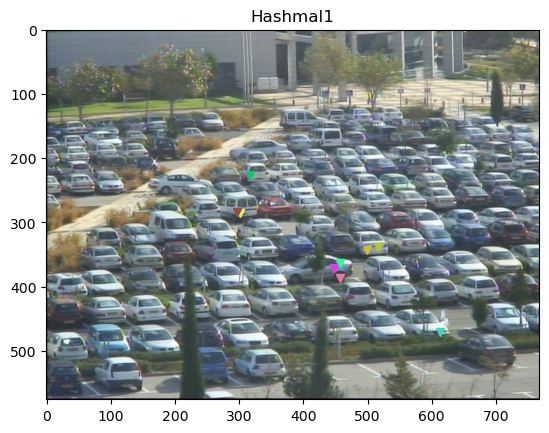

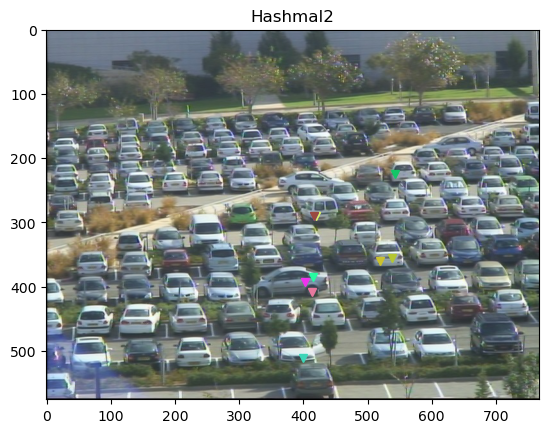

In [32]:
x = np.random.rand(10)
y = np.random.rand(10)
z = np.random.rand(10)

data = plt.imread(train_picture[1])
for row  in enumerate(df_10_best_ratios.values):
    plt.plot(df_train_Hashmal.Y[df_10_best_ratios.values[row[0]][0][0][0]],
             df_train_Hashmal.X[df_10_best_ratios.values[row[0]][0][0][0]], marker='v',
             color=(x[row[0]], y[row[0]], z[row[0]]))
plt.imshow(data)
label = 'Hashmal1'
plt.title(label, fontdict=None, loc='center')
plt.show()

data = plt.imread(test_picture[1])
for row  in enumerate(df_10_best_ratios.values):
    ind = df_10_best_ratios.values[row[0]][1]
    plt.plot(df_test_Hashmal.values[ind][1],
             df_test_Hashmal.values[ind][0], marker='v',
             color=(x[row[0]], y[row[0]], z[row[0]]))
plt.imshow(data)
label = 'Hashmal2'
plt.title(label, fontdict=None, loc='center')
plt.show()

#### All 10 points in Hashmal1 and Hashmal2 match.

As can be seen in the images above, only 9 points are displayed. After intensive checks, we found out that 2 points (out of the displayed 10) on each dataset, have the exactly same coordinates of (X,Y) - meaning the points overlap.

The overlapping points are:

point index = 2449,2450  
X =296.96 Y = 283.87 (Hasmal1) <br>

point index = 2334,2335  
X =289.2 Y = 416.03 (Hasmal2) <br>

Remark:<br>
Each of the overlapping points have a different scale and angle (which makes them unique) but the images only display the X,Y coordinates of each point. 





# Task 4
Searching for the values which will cause the optimal result (minimized mean error)

## Function for calculating the mean error and measuring run time:
We calculated the mean error using two different methods:
<br>
1) *Mean error based only on points for which, a nearest neighbor was found.<br> 
   Points without nearest neighbor were omitted from the mean error but counted and displayed for each iteration.*

2) *Normalized mean error for all points using weights based on frequency:*
<br>

<b>E1</b> = Error for points with nearest neighbor, it was calculated using the formula given in the instructions.<br>
<b>E2</b> = Error for each point without a neighbor is set to 1.<br>
<b>W1</b> = Amount of points with neighbor / total amount of points.<br> 
<b>W2</b> = Amount of points without neighbor / total amount of points.<br>
<b>Normalized_Mean_Error = E1*W1 + E2*W2</b>

These results can be seen in the table below and also the calculated time for each iteration.

In [79]:
def mean_error(dataset_x, dataset_y, knn_result, k, l):
    
    ann_iteration = ANN(l, k, 128)
    ann_iteration.fit(dataset_x)
    
    start = perf_counter()
    ann_results = ann_iteration.kneighbors(dataset_y, 1)
    end = perf_counter()
    elapsed_time = str(end - start)
    mean_error_result = 0
    count = 0     # counter for points without a neighbor
    for i in range(len(dataset_y)):
        if ann_results[i][0] is not None:
            # in case the algorithm found k neighbors
            ann_distance = ann_results[i][0][0][1]
            knn_distance = knn_result[i][0][0][1]
            epsilon_point_y = (ann_distance / knn_distance) - 1
            mean_error_result += epsilon_point_y
        else:
            count += 1
            
    good_points_error = mean_error_result/len(dataset_y)           # E1
    bad_points_error = 1                                           # E2
    good_points_weight = (len(dataset_y) - count)/len(dataset_y)   # W1
    bad_points_weight = count/len(dataset_y)                       # W2
    
    # calculating the mean error using method 1
    error = mean_error_result / (len(dataset_y) - count) 
    # normalize the results according to method 2
    normalized_error = good_points_error * good_points_weight + bad_points_error * bad_points_weight
    return normalized_error, elapsed_time, count, error

### Hananya dataset
Executing the mean error function for Hananya:

In [35]:
knn = KNN()
knn.fit(df_train_Hananya)
knn_result_hananya = knn.kneighbors(df_test_numpy_Hananya, 1)

normalized_error_list = []
error_list = []
count_list = []
time_list = []
k_list =[]
l_list = []
normalized_error_matrix = np.zeros((10,10))
error_matrix = np.zeros((10,10))
time_matrix = np.zeros((10,10))
count_matrix = np.zeros((10,10))

# The parameters we chose to test for finding the optimal result:
for l in range(2,12):
    for k in range(4,14):
        normalized_error, time, count, error = mean_error(df_train_Hananya, df_test_numpy_Hananya, knn_result_hananya, k, l)
        normalized_error_list.append(normalized_error)
        
        error_list.append(error)
        count_list.append(count)
        time_list.append(time)
        k_list.append(k)
        l_list.append(l)
        

        normalized_error_matrix[l-2][k-4]  =  normalized_error   
        error_matrix[l-2][k-4]  =  error
        time_matrix[l-2][k-4]  =  time
        count_matrix[l-2][k-4] = count

Displaying results from the 100 iterations in a dataframe:

In [36]:
df_mean_error = pd.DataFrame()
df_mean_error.insert(0, "K", k_list)
df_mean_error.insert(1, "l", l_list)
df_mean_error.insert(2, "Normalized Error", normalized_error_list)
df_mean_error.insert(3, "Standard Error", error_list)
df_mean_error.insert(4, "Runtime", time_list)
df_mean_error.insert(5, "Points without NN", count_list)

df_mean_error

,K,l,Normalized Error,Standard Error,Runtime,Points without NN
0,4,2,0.030772,0.030772,14.151112799998373,0
1,5,2,0.040654,0.040654,10.907350900000893,0
2,6,2,0.053821,0.053821,7.275254000007408,0
3,7,2,0.082872,0.082872,6.276891000001342,0
4,8,2,0.106896,0.106033,5.392778699999326,1
...,...,...,...,...,...,...
95,9,11,0.008808,0.008808,8.676684100006241,0
96,10,11,0.013551,0.013551,5.829866599990055,0
97,11,11,0.027363,0.027363,3.576066300011007,0
98,12,11,0.042035,0.042035,3.0741773000045214,0


The best hyper parameter (K,L) found (minimal normalized error):

In [38]:
df_mean_error.nsmallest(1,'Normalized Error')

,K,l,Normalized Error,Standard Error,Runtime,Points without NN
80,4,10,0.000119,0.000119,24.089323699998204,0


We will analyze the received results in heatmap diagrams:

Text(95.72222222222221, 0.5, 'L')

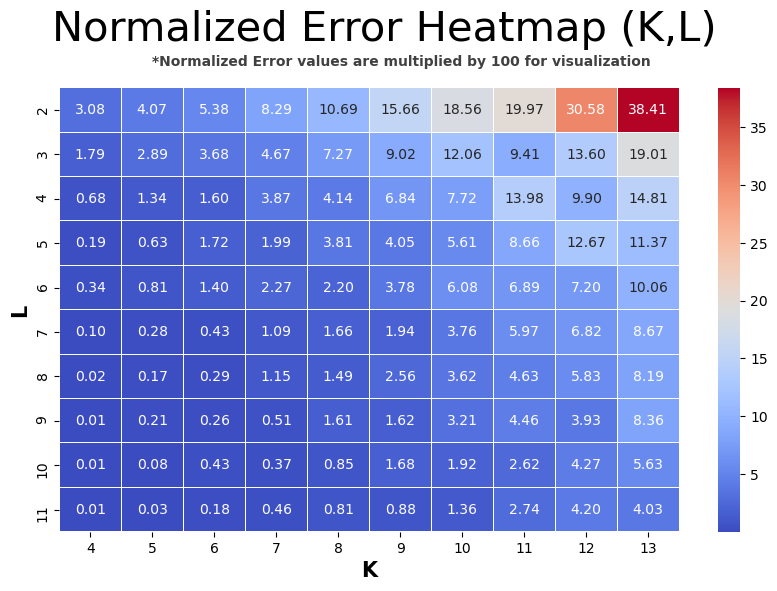

In [39]:
# Normalized error matrix - Heatmap
f, ax = plt.subplots(figsize=(10, 6))
k_axis_labels = [4,5,6,7,8,9,10,11,12,13] # labels for x-axis
l_axis_labels = [2,3,4,5,6,7,8,9,10,11] # labels for y-axis

hm = sns.heatmap(normalized_error_matrix*100, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05,xticklabels=k_axis_labels, yticklabels=l_axis_labels)
f.subplots_adjust(top=0.85)
t= f.suptitle('Normalized Error Heatmap (K,L)', fontsize=30,x=0.45)
plt.text(x=1.5, y=-.5, s='*Normalized Error values are multiplied by 100 for visualization', 
         fontsize=10, alpha=0.75,fontweight='bold')
plt.xlabel("K",fontweight='bold',fontsize=15)
plt.ylabel("L",fontweight='bold',fontsize=15)

**Analysis for Normalized Error Heatmap**:

In the heatmap, x axis is K (number of cuts) and y axis is L (number of tables), we can see that:
* The normalized mean error is minimized when K is minimized and L is maximized (blue area, bottom left corner) 
* The normalized mean error is maximized when K is maxiized and L is minimized (red area, top right corner) 


Text(133.22222222222223, 0.5, 'L')

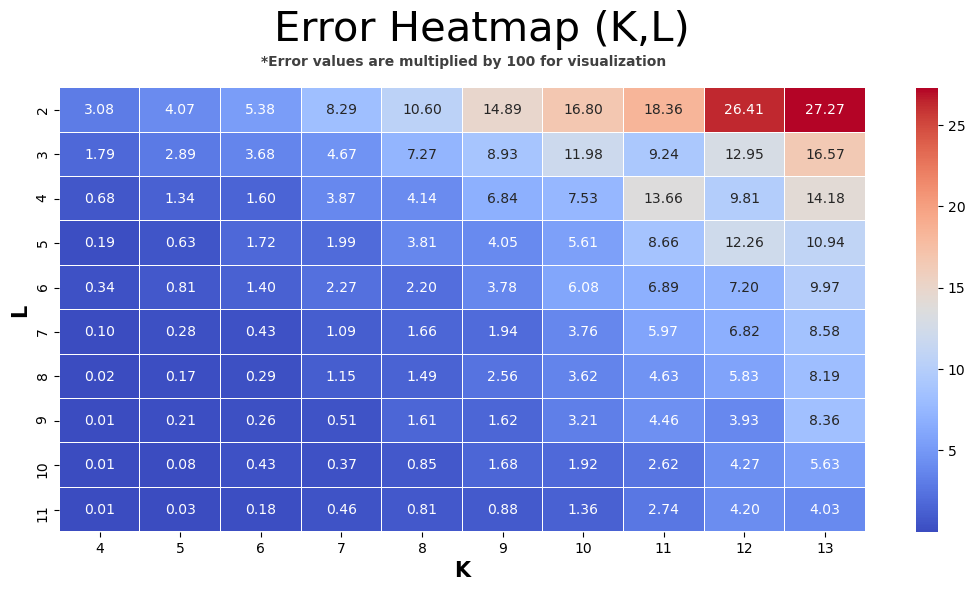

In [40]:
# Error Matrix  - Heatmap
f, ax = plt.subplots(figsize=(13, 6))
k_axis_labels = [4,5,6,7,8,9,10,11,12,13] # labels for x-axis
l_axis_labels = [2,3,4,5,6,7,8,9,10,11] # labels for y-axis

hm = sns.heatmap(error_matrix*100, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05,xticklabels=k_axis_labels, yticklabels=l_axis_labels)
f.subplots_adjust(top=0.85)
t= f.suptitle('Error Heatmap (K,L)', fontsize=30,x=0.45)
plt.text(x=2.5, y=-.5, s='*Error values are multiplied by 100 for visualization', 
         fontsize=10, alpha=0.75,fontweight='bold')
plt.xlabel("K",fontweight='bold',fontsize=15)
plt.ylabel("L",fontweight='bold',fontsize=15)


**Analysis for Error Heatmap**:

As in the heatmap of the normalized mean error , the same logic applies here, so the heatmap looks generally the same.
In Addition, we notice that on average, each value in this heatmap is a bit higher than in the normalized error heatmap.

This is expected as this error only considers points with a neighbor and doesn't consider the points without a nearest neighnor as mistakes. On the other hand, the normalized error assigns 1 (maximum error) to all the points without a neighbor,<br>
this causes the total mean error to be higher than in the first heatmap.  

Text(133.22222222222223, 0.5, 'L')

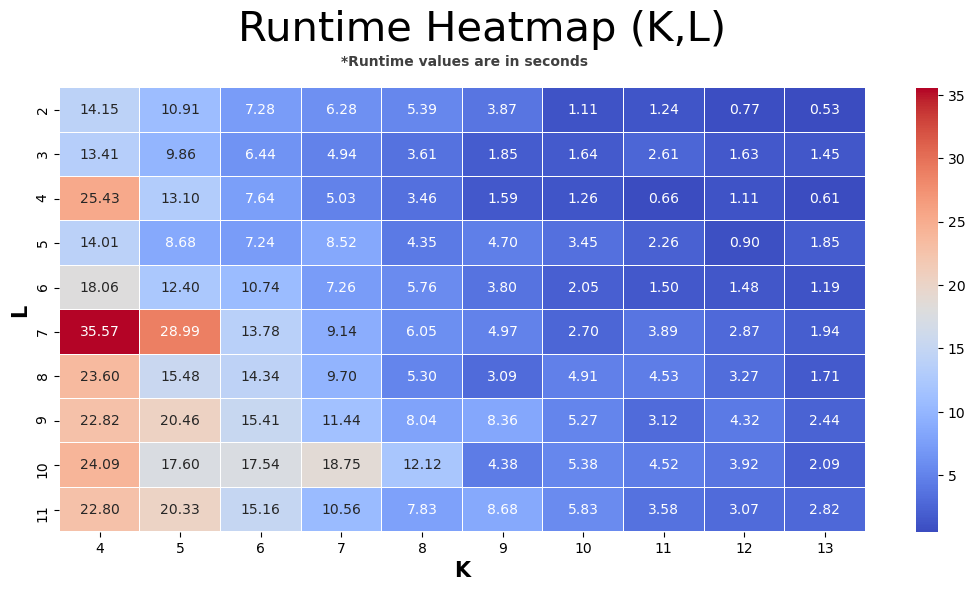

In [41]:
# Runtime Matrix  - Heatmap
f, ax = plt.subplots(figsize=(13, 6))
k_axis_labels = [4,5,6,7,8,9,10,11,12,13] # labels for x-axis
l_axis_labels = [2,3,4,5,6,7,8,9,10,11] # labels for y-axis

hm = sns.heatmap(time_matrix, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05,xticklabels=k_axis_labels, yticklabels=l_axis_labels)
f.subplots_adjust(top=0.85)
t= f.suptitle('Runtime Heatmap (K,L)', fontsize=30,x=0.45)
plt.text(x=3.5, y=-.5, s='*Runtime values are in seconds', 
         fontsize=10, alpha=0.75,fontweight='bold')
plt.xlabel("K",fontweight='bold',fontsize=15)
plt.ylabel("L",fontweight='bold',fontsize=15)

**Analysis for Runtime Heatmap**:

The red areas represent long runtimes, this happens when K values are low and L values are high.<br>
This is expected because K is the number of cuts and determines the hash size each hash table.

As the hash size decreases, more points are mapped to the same hash key,
therefore more distances will be calculated (for all the points in the cell,found for that hash key)

Also, when L (the number of tables) is increased, the algorithm executes more iterations, so the runtime increases accordingly.

Text(133.22222222222223, 0.5, 'L')

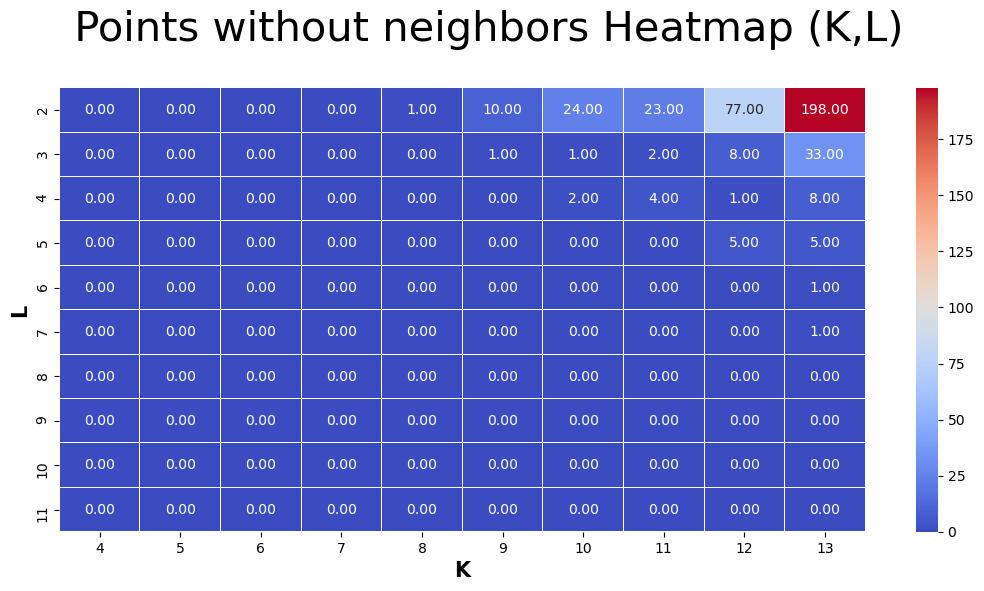

In [43]:
# Point without neighbors Matrix  - Heatmap
f, ax = plt.subplots(figsize=(13, 6))
k_axis_labels = [4,5,6,7,8,9,10,11,12,13] # labels for x-axis
l_axis_labels = [2,3,4,5,6,7,8,9,10,11] # labels for y-axis

hm = sns.heatmap(count_matrix, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05,xticklabels=k_axis_labels, yticklabels=l_axis_labels)
f.subplots_adjust(top=0.85)
t= f.suptitle(' Points without neighbors Heatmap (K,L)', fontsize=30,x=0.45)

plt.xlabel("K",fontweight='bold',fontsize=15)
plt.ylabel("L",fontweight='bold',fontsize=15)

**Analysis for Points without neighbors Heatmap**:

This heatmap shows for each K,L values the number of points for which a nearest neighbor wasn't found. We can see that as K increases and L decreases, the chance that a neighbor will not be found increases.

This is expected becauses as K increases (hash key size) , fewer points are mapped to that key (a single cell in the hash table).
When L is increased, more tables exist and there is more chance that a neighbor will be found in one of them. Therfore, if L is small, fewer table exists and the chance that a neighbor won't be found increases.

### Hashmal dataset
Executing the mean error function for Hashmal:

In [44]:
knn = KNN()
knn.fit(df_train_Hashmal)
knn_result_hashmal = knn.kneighbors(df_test_numpy_Hashmal, 1)

normalized_error_list = []
error_list = []
count_list = []
time_list = []
k_list =[]
l_list = []
normalized_error_matrix = np.zeros((10,10))
error_matrix = np.zeros((10,10))
time_matrix = np.zeros((10,10))
count_matrix = np.zeros((10,10))

# The parameters we chose to test for finding the optimal result:
for l in range(10,20):
    for k in range(20,30):
        normalized_error, time, count, error = mean_error(df_train_Hashmal, df_test_numpy_Hashmal, knn_result_hashmal, k, l)
        normalized_error_list.append(normalized_error)
        
        error_list.append(error)
        count_list.append(count)
        time_list.append(time)
        k_list.append(k)
        l_list.append(l)
        

        normalized_error_matrix[l-10][k-20]  =  normalized_error   
        error_matrix[l-10][k-20]  =  error
        time_matrix[l-10][k-20]  =  time
        count_matrix[l-10][k-20] = count

Displaying results from the 100 iterations in a dataframe:

In [45]:
df_mean_error = pd.DataFrame()
df_mean_error.insert(0, "K", k_list)
df_mean_error.insert(1, "l", l_list)
df_mean_error.insert(2, "Normalized Error", normalized_error_list)
df_mean_error.insert(3, "Standard Error", error_list)
df_mean_error.insert(4, "Runtime", time_list)
df_mean_error.insert(5, "Points without NN", count_list)

df_mean_error

,K,l,Normalized Error,Standard Error,Runtime,Points without NN
0,20,10,0.228477,0.207590,5.82934430000023,143
1,21,10,0.240622,0.217090,5.791097799999989,166
2,22,10,0.269790,0.233219,5.598751700003049,270
3,23,10,0.294176,0.243377,5.182102199993096,384
4,24,10,0.379724,0.283301,6.570135499991011,799
...,...,...,...,...,...,...
95,25,19,0.286568,0.228608,3.2815517999988515,415
96,26,19,0.352011,0.256394,3.4446554000023752,727
97,27,19,0.394949,0.270515,3.182526599994162,964
98,28,19,0.392500,0.262471,5.131731000001309,979


The best hyper parameter (K,L) found (minimal normalized error):

In [46]:
df_mean_error.nsmallest(1,'Normalized Error')

,K,l,Normalized Error,Standard Error,Runtime,Points without NN
90,20,19,0.099642,0.099444,5.747072099999059,1


We will analyze the received results in heatmap diagrams:<br>
In Hashmal, we just display the same heatmaps as in Hananya, we don't add the anaylsis for the heatmaps as it is exactly that same as in Hananya

Text(133.22222222222223, 0.5, 'L')

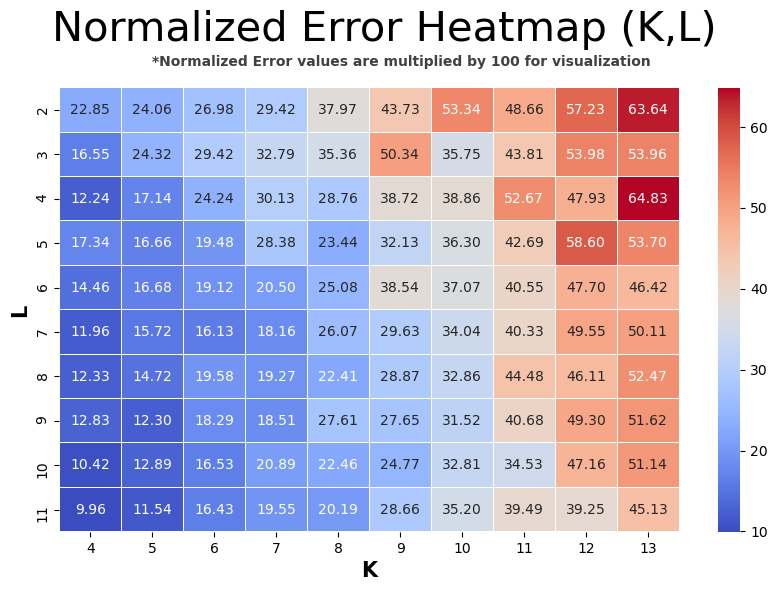

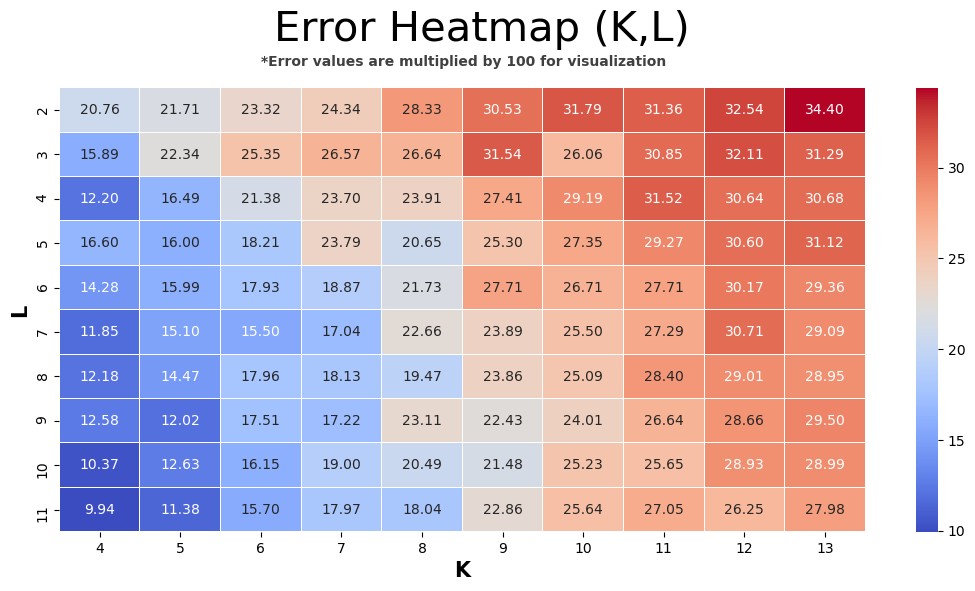

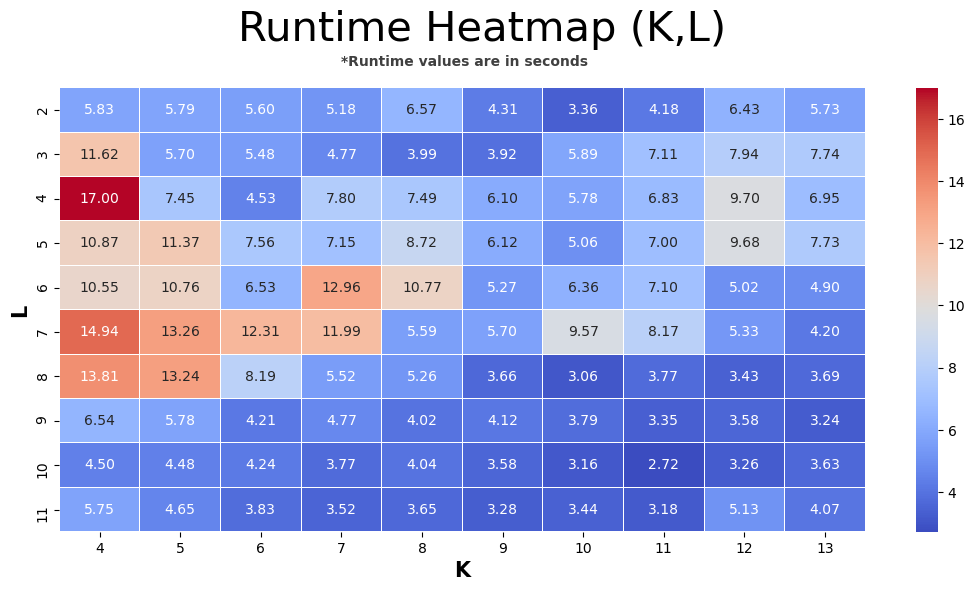

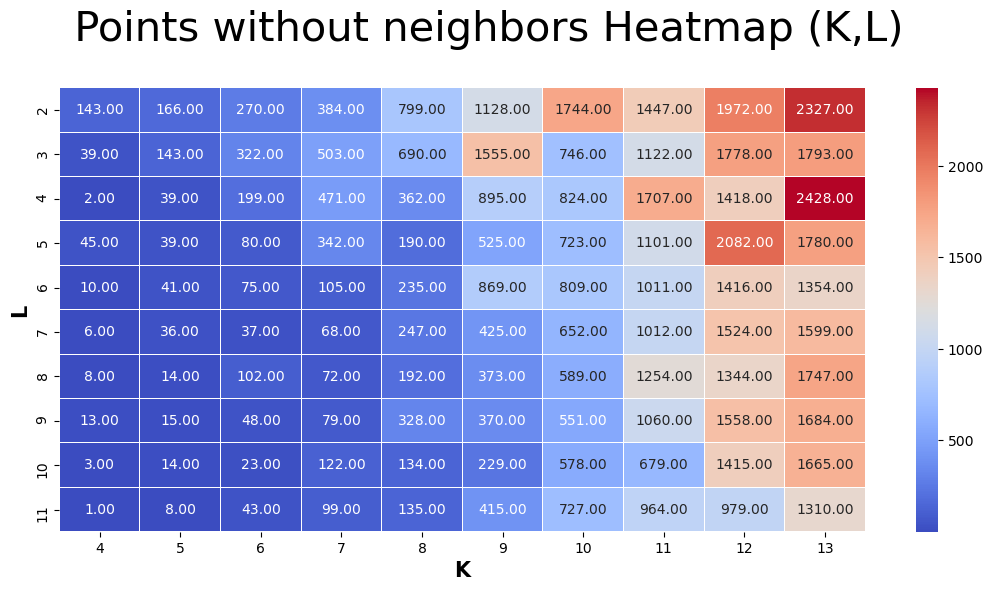

In [47]:
# Normalized error matrix - Heatmap
f, ax = plt.subplots(figsize=(10, 6))
k_axis_labels = [4,5,6,7,8,9,10,11,12,13] # labels for x-axis
l_axis_labels = [2,3,4,5,6,7,8,9,10,11] # labels for y-axis

hm = sns.heatmap(normalized_error_matrix*100, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05,xticklabels=k_axis_labels, yticklabels=l_axis_labels)
f.subplots_adjust(top=0.85)
t= f.suptitle('Normalized Error Heatmap (K,L)', fontsize=30,x=0.45)
plt.text(x=1.5, y=-.5, s='*Normalized Error values are multiplied by 100 for visualization', 
         fontsize=10, alpha=0.75,fontweight='bold')
plt.xlabel("K",fontweight='bold',fontsize=15)
plt.ylabel("L",fontweight='bold',fontsize=15)

# Error Matrix  - Heatmap
f, ax = plt.subplots(figsize=(13, 6))
k_axis_labels = [4,5,6,7,8,9,10,11,12,13] # labels for x-axis
l_axis_labels = [2,3,4,5,6,7,8,9,10,11] # labels for y-axis

hm = sns.heatmap(error_matrix*100, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05,xticklabels=k_axis_labels, yticklabels=l_axis_labels)
f.subplots_adjust(top=0.85)
t= f.suptitle('Error Heatmap (K,L)', fontsize=30,x=0.45)
plt.text(x=2.5, y=-.5, s='*Error values are multiplied by 100 for visualization', 
         fontsize=10, alpha=0.75,fontweight='bold')
plt.xlabel("K",fontweight='bold',fontsize=15)
plt.ylabel("L",fontweight='bold',fontsize=15)

# Runtime Matrix  - Heatmap
f, ax = plt.subplots(figsize=(13, 6))
k_axis_labels = [4,5,6,7,8,9,10,11,12,13] # labels for x-axis
l_axis_labels = [2,3,4,5,6,7,8,9,10,11] # labels for y-axis

hm = sns.heatmap(time_matrix, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05,xticklabels=k_axis_labels, yticklabels=l_axis_labels)
f.subplots_adjust(top=0.85)
t= f.suptitle('Runtime Heatmap (K,L)', fontsize=30,x=0.45)
plt.text(x=3.5, y=-.5, s='*Runtime values are in seconds', 
         fontsize=10, alpha=0.75,fontweight='bold')
plt.xlabel("K",fontweight='bold',fontsize=15)
plt.ylabel("L",fontweight='bold',fontsize=15)

# Point without neighbors Matrix  - Heatmap
f, ax = plt.subplots(figsize=(13, 6))
k_axis_labels = [4,5,6,7,8,9,10,11,12,13] # labels for x-axis
l_axis_labels = [2,3,4,5,6,7,8,9,10,11] # labels for y-axis

hm = sns.heatmap(count_matrix, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05,xticklabels=k_axis_labels, yticklabels=l_axis_labels)
f.subplots_adjust(top=0.85)
t= f.suptitle(' Points without neighbors Heatmap (K,L)', fontsize=30,x=0.45)

plt.xlabel("K",fontweight='bold',fontsize=15)
plt.ylabel("L",fontweight='bold',fontsize=15)


# Task 5
------------

## *Finding  top 5 $K,L$ combinations (out of $150$) for $\epsilon = 0.1$, with shortest ANN runtime*:
---

### Steps:
1. We set the wanted mean error ($\epsilon$) to 0.1
<br><br>
2. We run our 'mean_error' method iteratively, trying $150$ combinations of hyper paramteres ($k,L$)
<br><br>
3. For each combinaton we calculate the runtime and mean_error, if mean_error < wanted error $(0.1)$ => we add this
   combination to our result array, if calculated mean_error > $0.1$ => we ignore this combination.
<br><br>
4. We sort that list by runtime and return $5$ top combinations from our result list with shortest runtimes.
<br><br>
5. These 5 top combination and their runtimes are presented in a bar chart

#### Method for finding 5 top combinations (according to runtime)

In [54]:
def bestParamsForEps(wanted_mean_error,dataset_x,dataset_y,k_max,k_min,l_max,l_min,knn_result):
    best_params = list()
    for l in range(l_min, l_max):
        for k in range(k_max, k_min,-1):
            normalized_error, elapsed_time, count, error = mean_error(dataset_x, dataset_y,knn_result, k, l)
            if normalized_error <= wanted_mean_error:
                best_params.append((k, l, normalized_error, elapsed_time))
    best_params.sort(key=lambda line: line[3])
    top5 = itertools.islice(best_params, 5)
    return (tuple(top5))

### Hananaya dataset

We choose 15 values of K and 10 values of L, from which we select the best values

In [ ]:
l_max_hananya = 11
l_min_hananya = 1
k_max_hananya = 15
k_min_hananya = 1

best_params_hananya = bestParamsForEps(0.1,df_train_Hananya,df_test_numpy_Hananya,
                               k_max_hananya,k_min_hananya,l_max_hananya,l_min_hananya,knn_result_hananya)

#### Ploting the bar chart for displaying results

In [51]:
df_5_best_parameters_hananya = pd.DataFrame(best_params_hananya, columns = ['K','L','Error','Runtime'])
df_5_best_parameters_hananya

,K,L,Error,Runtime
0,11,5,0.081960,0.9764135000004899
1,9,3,0.072904,1.3350056999915978
2,15,10,0.082839,1.3474444000021322
3,14,10,0.070665,1.3558725000038976
4,14,9,0.071349,1.4443610000016633


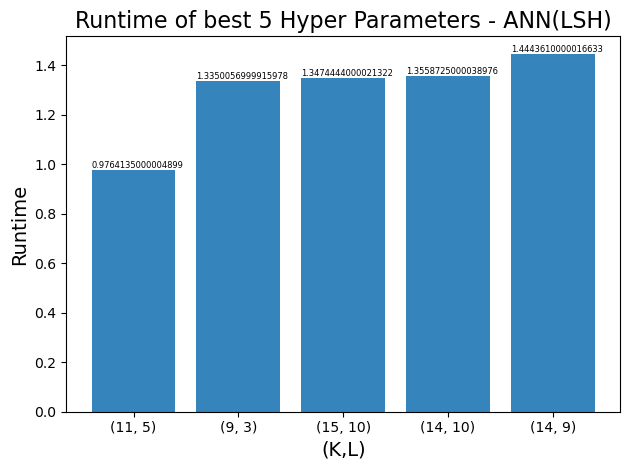

In [56]:
x_axis_for_graph = []
y_axis_for_graph = []
y_bars_labels = []

for i in range(len(best_params_hananya)):
    y_bars_labels.append(best_params_hananya[i][3])

for i in range(len(best_params_hananya)):
    x_axis_for_graph.append((best_params_hananya[i][0],best_params_hananya[i][1]))
for i in range(len(best_params_hananya)):
    y_axis_for_graph.append(float(best_params_hananya[i][3]))
    
y_pos = np.arange(len(y_axis_for_graph))
plt.bar(y_pos, y_axis_for_graph, align='center', alpha=0.9)

for i in range(len(y_axis_for_graph)):
    plt.text(x = i -0.4 , y = y_axis_for_graph[i]+0.01, s = y_bars_labels[i], size = 6)

plt.xticks(y_pos,x_axis_for_graph)
plt.ylabel('Runtime',size = 14)
plt.xlabel('('+'K,L'+')',size = 14)
plt.title('Runtime of best 5 Hyper Parameters - ANN(LSH)',size = 16)
plt.tight_layout()
plt.show()





### Hashmal dataset

In [ ]:
l_max_hashmal = 20
l_min_hashmal = 10
k_max_hashmal = 25
k_min_hashmal = 15

best_params_hashmal = bestParamsForEps(0.1,df_train_Hashmal,df_test_numpy_Hashmal,
                               k_max_hashmal,k_min_hashmal,l_max_hashmal,l_min_hashmal,knn_result_hashmal)

In [59]:
df_5_best_parameters_hashmal = pd.DataFrame(best_params_hashmal, columns = ['K','L','Error','Runtime'])
df_5_best_parameters_hashmal

,K,L,Error,Runtime
0,18,15,0.087900,10.540339899991523
1,18,17,0.069381,11.852483399998164
2,16,12,0.068828,12.501603600001545
3,17,15,0.075417,12.625695700000506
4,18,14,0.086435,12.863191099997493


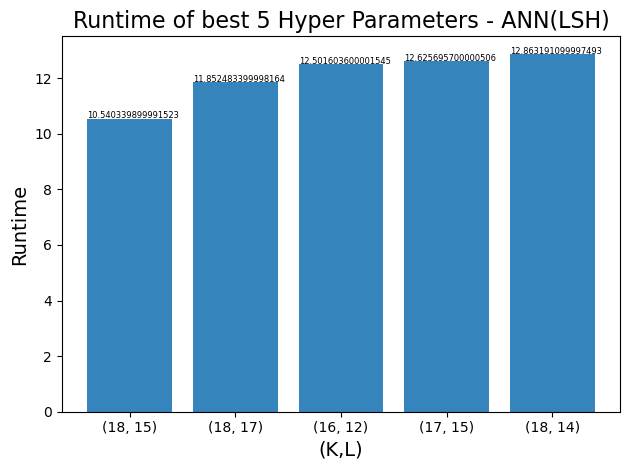

In [60]:
x_axis_for_graph = []
y_axis_for_graph = []
y_bars_labels = []

for i in range(len(best_params_hashmal)):
    y_bars_labels.append(best_params_hashmal[i][3])

for i in range(len(best_params_hashmal)):
    x_axis_for_graph.append((best_params_hashmal[i][0],best_params_hashmal[i][1]))
for i in range(len(best_params_hashmal)):
    y_axis_for_graph.append(float(best_params_hashmal[i][3]))
    
y_pos = np.arange(len(y_axis_for_graph))
plt.bar(y_pos, y_axis_for_graph, align='center', alpha=0.9)

for i in range(len(y_axis_for_graph)):
    plt.text(x = i -0.4 , y = y_axis_for_graph[i]+0.01, s = y_bars_labels[i], size = 6)

plt.xticks(y_pos,x_axis_for_graph)
plt.ylabel('Runtime',size = 14)
plt.xlabel('('+'K,L'+')',size = 14)
plt.title('Runtime of best 5 Hyper Parameters - ANN(LSH)',size = 16)
plt.tight_layout()
plt.show()

## *Analysis of $5$ best hyper parameters combinations: (for both Hananya & Hashmal)*

The imact of $K$ on the ANN's runtime and $Mean Error$ ($\epsilon$)
***
#### **Runtime -** 
**$K$:** <br>
We can clearly see that Runtime was minimized when $K$ value is high ($10\ge$ K $\ge 15$ for Hananya and $15\ge$ K $\ge 25$ for Hashmal). <br>
This was expected as hash key size is higher and so fewer points are mapped to each key (each cell in the the hash). <BR>
    
**$L$:** <br>
As L increases Runtime increases as number of hash tables increases so more total number of checked points in greater.
    
#### **Mean Error ($\epsilon$) -** 
**$K$:** <br>
When $K$ value increases, the Mean Error is also increases (and accuracy is decreased) as fewer points are checked in each cell of the hash table and chances   to find the optimal NN decrease.<br>
    
**$L$:**  
As $L$ value get increase, the Mean Error of ANN decreases as more random hash tables are generated, so the search span is more wide and diverse and chances that the optimal NN will be found are greater. <br>
    
### **Conclusion -**
***
There is a tradeoff between low Runtime and low Mean Error. When one is increased, the other one can be decreased. 
this tradeoff is also reflected in K and L value (higher L for more accuracy and higher K for decreasing runtime)



# Task 6
## Running ANN 10 times for the best $(K,L)$ combination found on task 5
--------------

We expect different results will be received in each iteration as hash keys are genertaed differently in each hash table in each iteration. 

### Hananya dataset

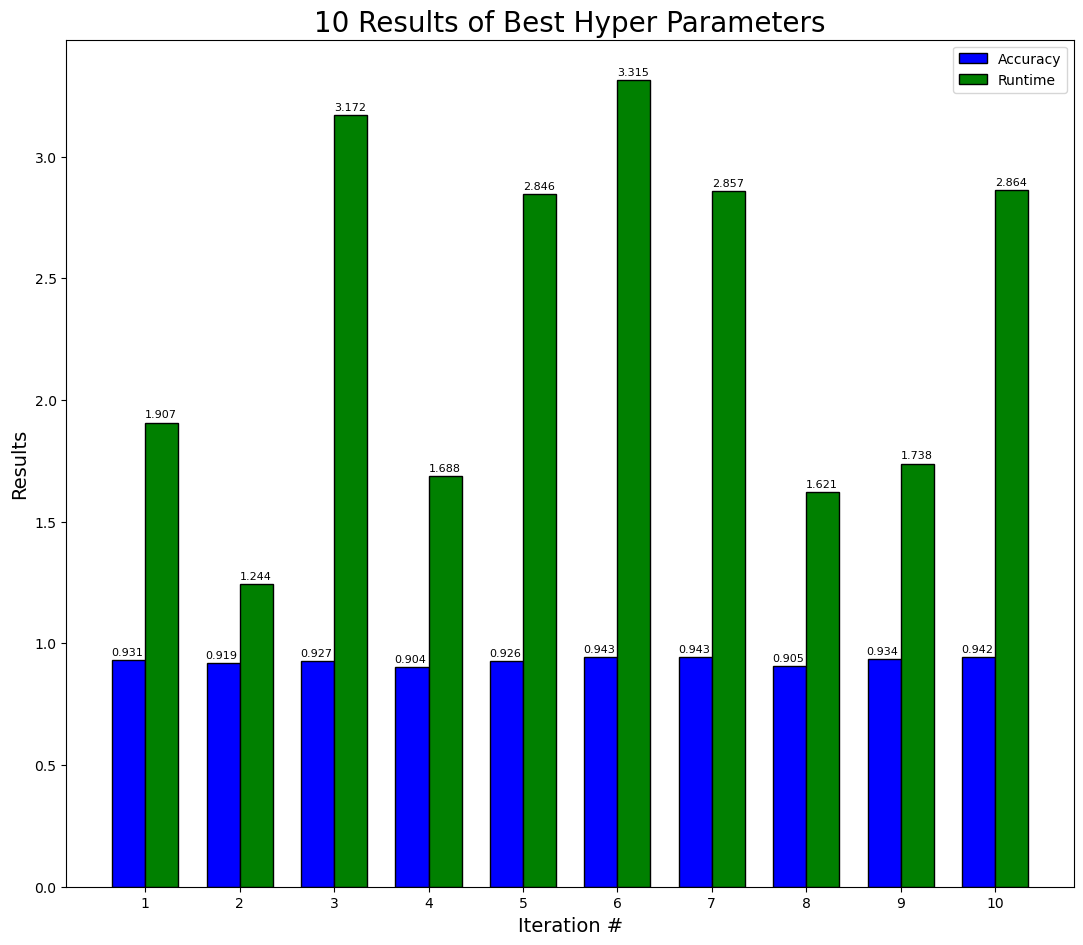

In [80]:
accuracy = []
run_time = []

# Grabing best (K,L) combination from task 5 results
best_k_from_task5 = best_params_hananya[0][0] 
best_l_from_task5 = best_params_hananya[0][1]


for i in range(10):
    epsilon1, time1, count1, error1 = mean_error(df_train_Hananya, df_test_numpy_Hananya, 
                                                 knn_result_hananya, best_k_from_task5, best_l_from_task5)
    accuracy.append(1-epsilon1)
    run_time.append(time1)

accuracy_num_hananya = [float(i) for i in accuracy]
run_time_num_hananya = [float(i) for i in run_time]

r = np.arange(10)
width = 0.35
plt.figure(figsize=(13,11))
plt.bar(r, accuracy_num_hananya, color = 'b',
        width = width, edgecolor = 'black',
        label='Accuracy')
plt.bar(r + width, run_time_num_hananya, color = 'g',
        width = width, edgecolor = 'black',
        label='Runtime')
plt.xlabel('Iteration #',size = 14)
plt.ylabel('Results',size = 14)
plt.title('10 Results of Best Hyper Parameters',size = 20) 
plt.xticks(r + width/2,['1','2','3','4','5','6','7','8','9','10'])

for i in range(len(r)):
    plt.text(x = i - width/2 - 0.01 , y = accuracy_num_hananya[i]+0.02, s = round(accuracy_num_hananya[i],3), size = 8)

for i in range(len(r)):
    plt.text(x = i + width/2 , y = run_time_num_hananya[i]+0.02, s = round(run_time_num_hananya[i],3), size = 8)
    
plt.legend()
  
plt.show()

### Hashmal dataset

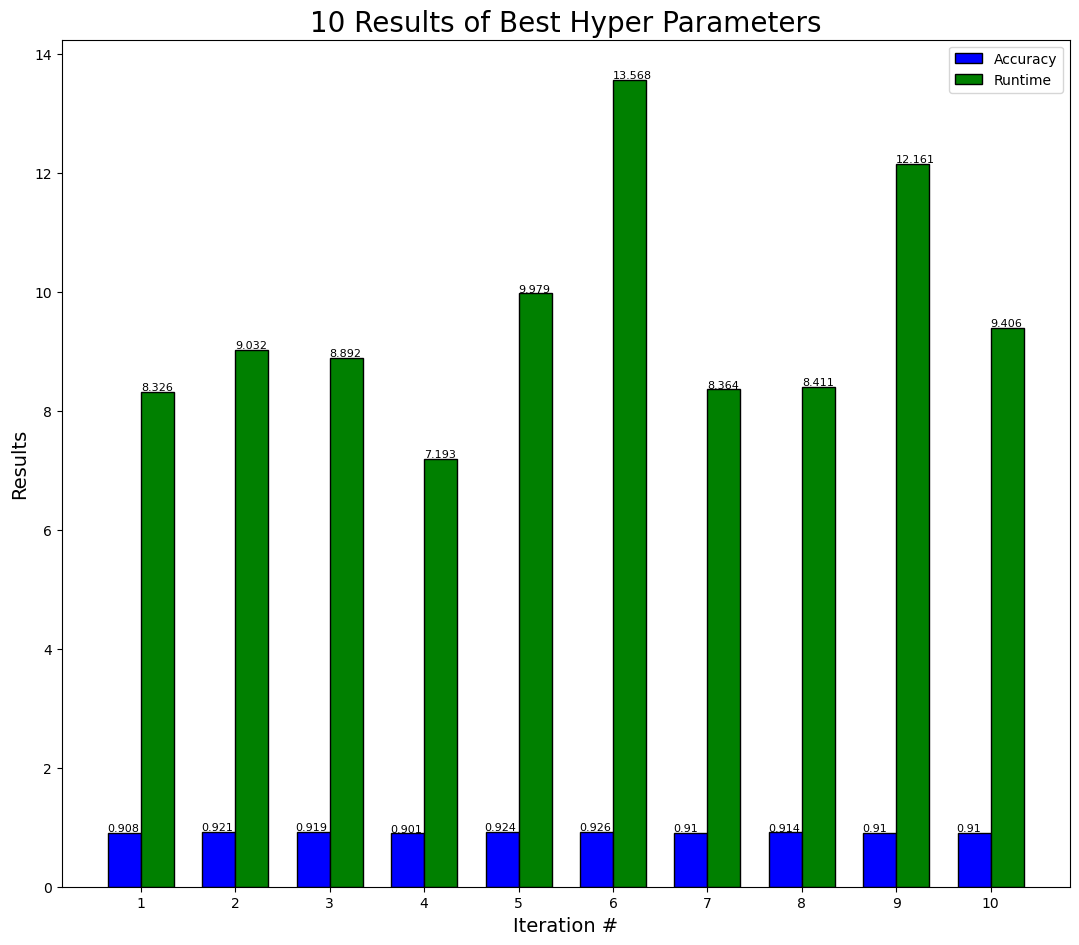

In [81]:
accuracy = []
run_time = []

# Grabing best (K,L) combination from task 5 results
best_k_from_task5 = best_params_hashmal[0][0] 
best_l_from_task5 = best_params_hashmal[0][1]


for i in range(10):
    epsilon1, time1, count1, error1 = mean_error(df_train_Hashmal, df_test_numpy_Hashmal, knn_result_hashmal, 
                                                 best_k_from_task5, best_l_from_task5)
    accuracy.append(1-epsilon1)
    run_time.append(time1)

accuracy_num_hashmal = [float(i) for i in accuracy]
run_time_num_hashmal = [float(i) for i in run_time]

r = np.arange(10)
width = 0.35
plt.figure(figsize=(13,11))
plt.bar(r, accuracy_num_hashmal, color = 'b',
        width = width, edgecolor = 'black',
        label='Accuracy')
plt.bar(r + width, run_time_num_hashmal, color = 'g',
        width = width, edgecolor = 'black',
        label='Runtime')
plt.xlabel('Iteration #',size = 14)
plt.ylabel('Results',size = 14)
plt.title('10 Results of Best Hyper Parameters',size = 20) 
plt.xticks(r + width/2,['1','2','3','4','5','6','7','8','9','10'])

for i in range(len(r)):
    plt.text(x = i - width/2 - 0.01 , y = accuracy_num_hashmal[i]+0.02, s = round(accuracy_num_hashmal[i],3), size = 8)

for i in range(len(r)):
    plt.text(x = i + width/2 , y = run_time_num_hashmal[i]+0.02, s = round(run_time_num_hashmal[i],3), size = 8)
    
plt.legend()
  
plt.show()

### *Analysis of 10 iterations of the best (K,L) combination: (for both Hananya & Hashmal)*
---
#### **Accuracy -** 
We can see that accuracy flacuations are minor between the 10 iteraions, this was expected as we aimed to get the lowest runtime while still be at a mean error value < 0.1, so the chosen combination yields mean error ($\epsilon$) which is close to 0.1 (accuracy close to 0.9) on every iteration. <br>
#### **Runtime -** 

Unlike the accuracy, the runtime falcuate more drastically, this could indicate that runtime is more senstive to the randomness of the ANN generated projection array (hash key generator) which is based on different cuts and values on each iteration.


# Task 7
---
### *Analysis of sklearn algorithm  performance compared to our own ANN*
#### Steps:

1. **Defining mean_error** ($\epsilon$)  method for skleran algorithm (will recieve train dataset,KNN results and SKlearn algorithm type as input parameters, will execute sklearn's ANN and will return the Mean error & Runtime


2. **Optimization of the sklearn algorithm** to find best hyper parameters combination 
    (['auto', 'ball_tree', 'kd_tree', 'brute'], leaf size) by executing mean error method with 48 combinations of the hyper
    parameters, all results are exported to dataframe and displayed
    

3. **Comparison of the best sklearn hyper result (combination) with  our ANN best 10 results** from task 6:
   The comparison will be displayed in a bar chart which will include the same 10 runtimes & accuracy values of our ANN
   from task 6 together with the sklearn runtime and accuracy 
    
    *We thought that showing our 10 best result from task 6  together with Sklearn best result found in this task will the efficient way to compare the two. 


In [82]:
def mean_error_sklearn(dataset_x, dataset_y, knn_result, leaf_size, algo):
    train_data = np.array(dataset_x)[:, 4:]
    test_data = np.array(dataset_y)[:, 4:]
    ann_sklearn = NearestNeighbors(n_neighbors=1, algorithm=algo, leaf_size=leaf_size).fit(train_data)
    start = perf_counter()
    sklearn_distances, sklearn_indexes = ann_sklearn.kneighbors(test_data)
    end = perf_counter()
    elapsed_time = str(end - start)
    mean_error_result = 0
    for i in range(len(test_data)):
        ann_distance = sklearn_distances[i]
        knn_distance = knn_result[i][0][0][1]
        epsilon = (ann_distance / knn_distance) - 1
        mean_error_result += epsilon

    return mean_error_result / len(test_data), elapsed_time

### Hananya Dataset
Optimization of Sklearn algorithm for our dataset (grid search)

In [62]:
algo = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_table = []
algo_table = []
accuracy_table = []
time_table = []

for leaf_size in range(5, 65, 5):
    for a in algo:
        mean_error, time = mean_error_sklearn(df_train_Hananya, df_test_Hananya, knn_result_hananya, leaf_size, a)
        leaf_table.append(leaf_size)
        algo_table.append(a)
        accuracy_table.append(1-mean_error)
        time_table.append(time)

# create table to display the results        
pd.set_option('display.max_rows', None)
df_mean_error_sklearn_hananya = pd.DataFrame()
df_mean_error_sklearn_hananya.insert(0, "Leaf_size", leaf_table)
df_mean_error_sklearn_hananya.insert(1, "Algorithm", algo_table)
df_mean_error_sklearn_hananya.insert(2, "Accuracy", accuracy_table)
df_mean_error_sklearn_hananya.insert(3, "Runtime", time_table)

df_mean_error_sklearn_hananya

,Leaf_size,Algorithm,Accuracy,Runtime
0,5,auto,[1.0],0.9401467999996385
1,5,ball_tree,[1.0],0.2873527999909129
2,5,kd_tree,[1.0],0.9723629000072833
3,5,brute,[1.0],0.04182270000455901
4,10,auto,[1.0],0.462160999988555
5,10,ball_tree,[1.0],0.20091410000168253
6,10,kd_tree,[1.0],0.5844386999960989
7,10,brute,[1.0],0.023648899994441308
8,15,auto,[1.0],0.4538500000053318
9,15,ball_tree,[1.0],0.2475336000061361


In [98]:
min_val = df_mean_error_sklearn_hananya['Runtime'].min()
md("The best received result after optimization is {} seconds".format(min_val))

The best received result after optimization is 0.011866200002259575 seconds

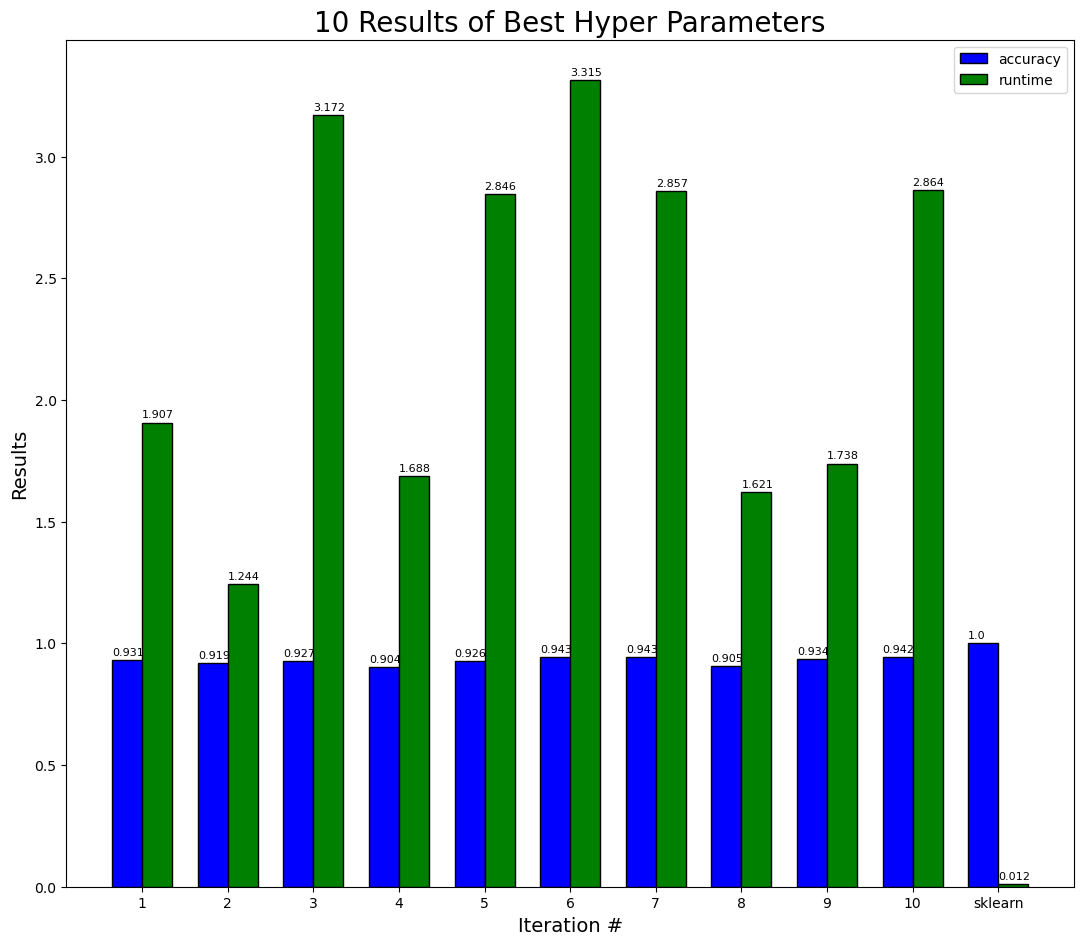

In [99]:
min_time_hananya = df_mean_error_sklearn_hananya.min()['Runtime']
min_time_float_hananya = float(min_time_hananya)
if len(accuracy_num_hananya) == 10:
    accuracy_num_hananya.append(1.0)
if len(run_time_num_hananya) == 10:
    run_time_num_hananya.append(min_time_float_hananya)
    
r = np.arange(11) 
width = 0.35
plt.figure(figsize=(13,11))
plt.bar(r, accuracy_num_hananya, color = 'b',
        width = width, edgecolor = 'black',
        label='accuracy')
plt.bar(r + width, run_time_num_hananya, color = 'g',
        width = width, edgecolor = 'black',
        label='runtime')
plt.xlabel('Iteration #',size = 14)
plt.ylabel('Results',size = 14)
plt.title('10 Results of Best Hyper Parameters',size = 20) 
plt.xticks(r + width/2,['1','2','3','4','5','6','7','8','9','10','sklearn'])

for i in range(len(r)):
    plt.text(x = i - width/2 , y = accuracy_num_hananya[i]+0.02, s = round(accuracy_num_hananya[i],3), size = 8)

for i in range(len(r)):
    plt.text(x = i + width/2 , y = run_time_num_hananya[i]+0.02, s = round(run_time_num_hananya[i],3), size = 8)
    
plt.legend()
  
plt.show()

### Hashmal Dataset
Optimization of Sklearn algorithm for our dataset (grid search)

In [181]:
algo = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_table = []
algo_table = []
accuracy_table = []
time_table = []

for leaf_size in range(5, 65, 5):
    for a in algo:
        mean_error, time = mean_error_sklearn(df_train_Hashmal, df_test_Hashmal, knn_result_hashmal, leaf_size, a)
        leaf_table.append(leaf_size)
        algo_table.append(a)
        accuracy_table.append(1-mean_error)
        time_table.append(time)

# create table to display the results        
pd.set_option('display.max_rows', None)
df_mean_error_sklearn_hashmal = pd.DataFrame()
df_mean_error_sklearn_hashmal.insert(0, "Leaf_size", leaf_table)
df_mean_error_sklearn_hashmal.insert(1, "Algorithm", algo_table)
df_mean_error_sklearn_hashmal.insert(2, "Accuracy", accuracy_table)
df_mean_error_sklearn_hashmal.insert(3, "Runtime", time_table)

df_mean_error_sklearn_hashmal

,Leaf_size,Algorithm,Accuracy,Runtime
0,5,auto,[1.0],24.24142540000321
1,5,ball_tree,[1.0],8.662562599994999
2,5,kd_tree,[1.0],23.520469100003538
3,5,brute,[1.0],0.4057855999999447
4,10,auto,[1.0],14.201761299998907
5,10,ball_tree,[1.0],6.434615800004394
6,10,kd_tree,[1.0],12.897999400003755
7,10,brute,[1.0],0.43376619999617105
8,15,auto,[1.0],13.506254300002183
9,15,ball_tree,[1.0],6.397325099998852


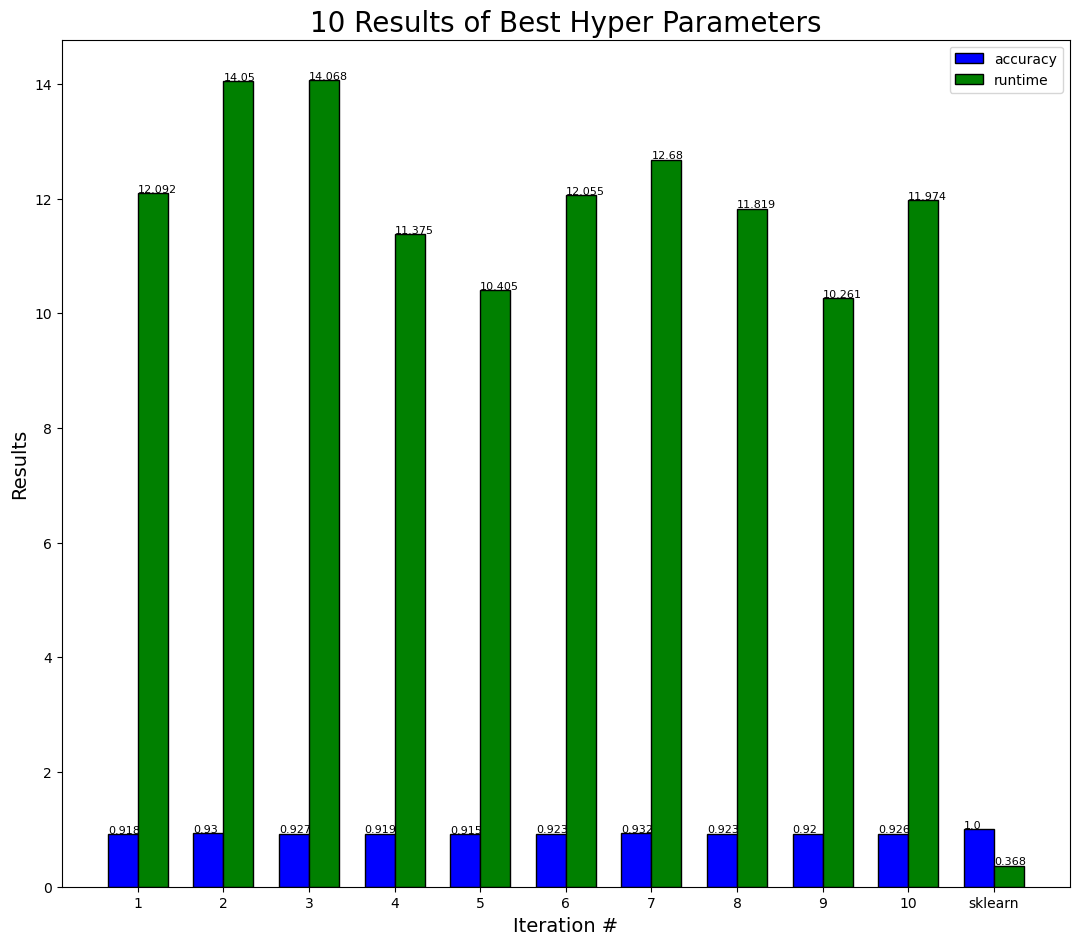

In [189]:
min_time_hashmal = df_mean_error_sklearn_hashmal.min()['Runtime']
min_time_float_hashmal = float(min_time_hashmal)
if len(accuracy_num_hashmal) == 10:
    accuracy_num_hashmal.append(1.0)
if len(run_time_num_hashmal) == 10:
    run_time_num_hashmal.append(min_time_float_hashmal)
    
r = np.arange(11) 
width = 0.35
plt.figure(figsize=(13,11))
plt.bar(r, accuracy_num_hashmal, color = 'b',
        width = width, edgecolor = 'black',
        label='accuracy')
plt.bar(r + width, run_time_num_hashmal, color = 'g',
        width = width, edgecolor = 'black',
        label='runtime')
plt.xlabel('Iteration #',size = 14)
plt.ylabel('Results',size = 14)
plt.title('10 Results of Best Hyper Parameters',size = 20) 
plt.xticks(r + width/2,['1','2','3','4','5','6','7','8','9','10','sklearn'])

for i in range(len(r)):
    plt.text(x = i - width/2 , y = accuracy_num_hashmal[i]+0.02, s = round(accuracy_num_hashmal[i],3), size = 8)

for i in range(len(r)):
    plt.text(x = i + width/2 , y = run_time_num_hashmal[i]+0.02, s = round(run_time_num_hashmal[i],3), size = 8)
    
plt.legend()
  
plt.show()

### *Analysis of 10 iterations of the best (K,L) combination: (for both Hananya & Hashmal)*
---
#### **$Accuracy$ -** 
On both Hananya and Hashmal, we can see that the SKlearn algorithm has a perfect $accuracy$ ($=1$), meaning it always found the same NN point which was also found by the brute force method of our KNN from task 1.<br>

Our own best ANN algorithm had also good accuracy of above 0.9 on all 10 iterations.
#### **$Runtime$ -** 

Like in the accuracy, the SKlearn's ANN also outperforms our ANN in terms of runtime by an order of magnitude.The SKlearn ANN ran fastest when using the brute force.   

### **Conclusion -**
***
The SKlearn algorithm performs better than our algorithm as expected, both in terms of accuracy and runtime. <br>
It was a bit surprising to see that the SKlearn had much better runtime also when using brute force compared to our LSH method.

This could be explained by use of some optimization techniques and the use of methods from other liberaries in the SKlearn code which weren't used in our implementation.

### Reference sources: 

https://towardsdatascience.com/locality-sensitive-hashing-for-music-search-f2f1940ace23